- L40
- runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04

In [1]:
!python --version

Python 3.11.10


In [2]:
!pip install scanpy scikit-misc scvi-tools mplscience igraph leidenalg

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 139.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 179.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 95.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 171.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import os
os.chdir('/workspace')
import gc
import warnings
warnings.filterwarnings("ignore")

# single cell pipelines
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

# scvi-tools
import scvi
import torch

print(scvi.__version__)
sc.logging.print_header()

np.random.seed(777)
torch.manual_seed(777)
scvi.settings.seed = 777

1.2.1


Seed set to 777


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.3 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [4]:
!pwd

/workspace


In [5]:
batch_key = 'sample_id'

In [6]:
!ls

annotated_subset.h5ad


In [7]:
adata = sc.read_h5ad('annotated_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 51879 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3', 'cnv_leiden', 'cnv_score', 'each_cell_type'

In [8]:
np.max(adata.X), np.min(adata.X)

(4177.0, 0.0)

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer = 'counts', flavor = 'seurat_v3', batch_key = batch_key, span = 0.5) 

In [10]:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts', batch_key='sample_id')
scvi_model = scvi.model.SCVI(adata, n_layers=2, dropout_rate= 0.5)  

In [11]:
scvi_model.train(early_stopping=True, datasplitter_kwargs={"drop_last": True}, )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/154 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=154` reached.


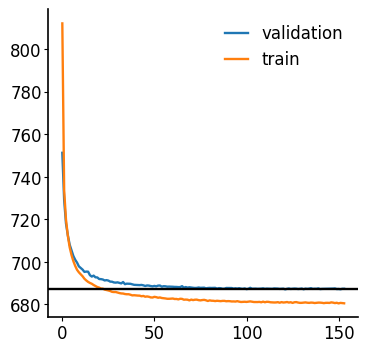

In [12]:
with mplscience.style_context():
    y = scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(scvi_model.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [15]:
with open('hvgs.txt', 'w') as f:
    for gene in adata.var_names:
        f.write(gene + '\n')

In [16]:
!ls

annotated_subset.h5ad  hvgs.txt


In [17]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

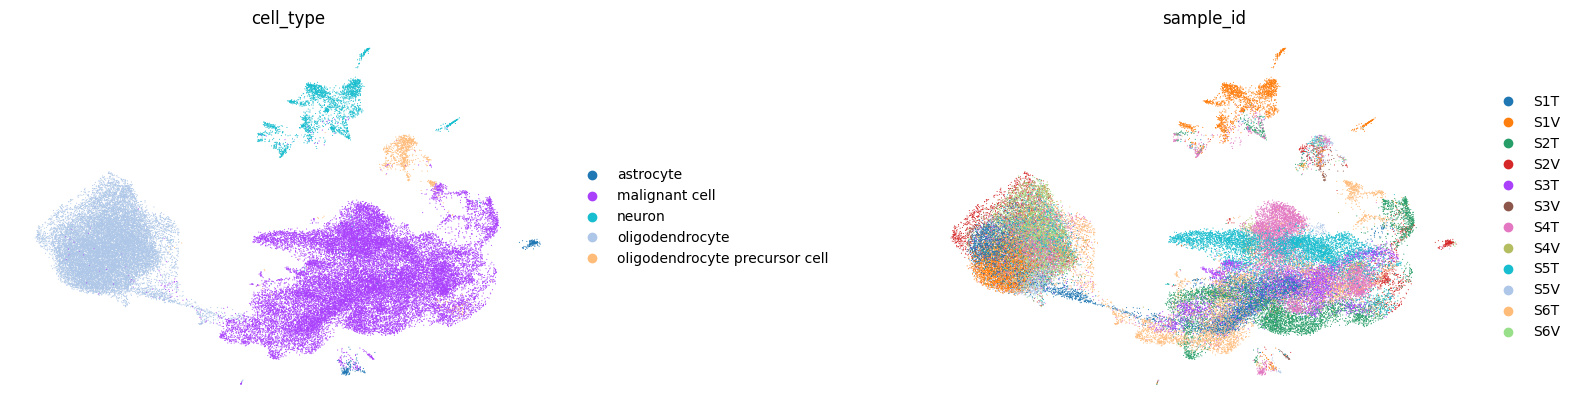

In [18]:
sc.pl.umap(adata, color = ['cell_type','sample_id'], wspace = 0.5, frameon = False, ncols = 2)

In [19]:
scvi_model.save('model_scvi_subset')

# 3. scANVI

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model= scvi_model, adata = adata, labels_key = 'cell_type', unlabeled_category='unlabelled')

In [21]:
scanvi_model.train(max_epochs = 30, early_stopping = True)

INFO     Training for 30 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
scanvi_model.save('model_scanvi_subset')

In [22]:
adata.layers['scvi_normalized'] = scvi_model.get_normalized_expression(library_size="latent")

In [23]:
adata.write('annotated_subset_with_hvg2000_corrected_matrix.h5ad')

In [25]:
# read again
adata = sc.read_h5ad('annotated_subset.h5ad')
adata.obsm['X_scVI'] = scvi_model.get_latent_representation()
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation()
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 51879 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3', 'cnv_leiden', 'cnv_score', 'each_cell_type'

In [1]:
import scanpy as sc

In [3]:
adata = sc.read_h5ad('../../output/annotated_subset_with_latent.h5ad')
adata

AnnData object with n_obs × n_vars = 51879 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3', 'cnv_leiden', 'cnv_score', 'each_cell_type'

In [4]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

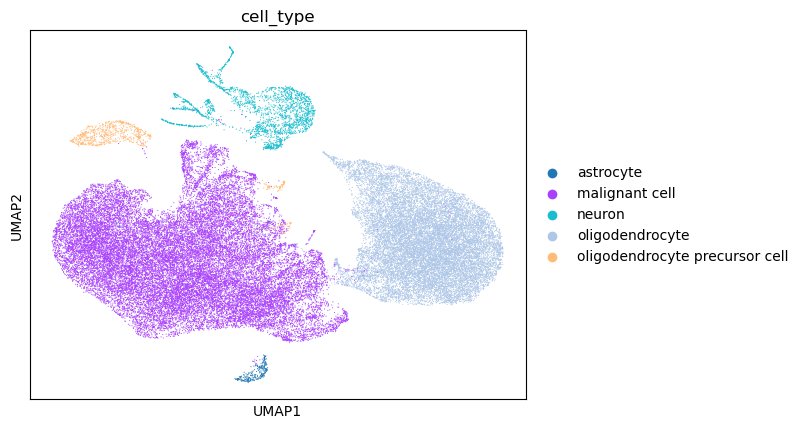

In [5]:
sc.pl.umap(adata, color = 'cell_type')

In [6]:
adata.write('annotated_subset_with_latent.h5ad')